# ハイスピードカメラ映像からの抽出

In [68]:
video_dir = "Chips2-2200Hz-Mary_MIDI-input.avi"

In [69]:
import pyrtools as pt
import cv2
from scipy import signal
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.io import wavfile
import pandas as pd
from time import time
from scipy.io.wavfile import write
import torch
import torchaudio
import numpy as np

In [62]:
'''
All functions written here is an implementation of the paper on 
Visual Microphone(http://people.csail.mit.edu/mrub/VisualMic/) 
by MIT. The algorithm and functions are inspired by the MATLAB code
provided by MIT.
'''

'\nAll functions written here is an implementation of the paper on \nVisual Microphone(http://people.csail.mit.edu/mrub/VisualMic/) \nby MIT. The algorithm and functions are inspired by the MATLAB code\nprovided by MIT.\n'

In [117]:
class VM:
    def __init__(self, video_path):
        self.video_object = cv2.VideoCapture(video_path)
        self.nframes = nframes = int(self.video_object.get(cv2.CAP_PROP_FRAME_COUNT))
        self.sr = 2200

    def align(self, x, y):
        # tshift = np.argmax(np.convolve(x, np.flip(y)))
        tshift = np.argmax(signal.fftconvolve(x, np.flip(y)))
        shift = y.size - tshift
        return np.roll(x,shift)
        
    def plot_spectogram(self, x, fs=2200, save=False):
        plt.figure()
        plt.specgram(x, Fs=fs, cmap=plt.get_cmap('jet'))
        plt.xlabel('Time (sec)')
        plt.ylabel('Frequency (Hz)')
        plt.colorbar().set_label('PSD(dB)')
        plt.savefig("spectrogram")

    def get_scaled_sound(self, sound):
        maxs = np.max(sound)
        mins = np.min(sound)

        if maxs!=1.0 or mins!=-1.0:
            rangev = maxs - mins
            print(f'max: {maxs}, mins: {mins}, rengev: {rangev}')
            sound = 2 * sound / rangev
            newmax = np.max(sound)
            offset = newmax - 1.0
            sound -= offset

        return sound

    def save_audio(self, file_name, sound, sr=0):
        if sr==0:
            sr = self.sr
        write(file_name, sr, x)

    def sound_from_video(self, nscale, norientation, downsample_factor, sample_rate=2200):
        nframes=self.nframes
        self.sr=sample_rate
        video=self.video_object
       
        suc,frame = video.read() #reading first frame and considering it reference frame
       
        if downsample_factor < 1:
            scaled_frame = cv2.resize(frame, (0, 0), fx=downsample_factor, fy=downsample_factor)
        else:
            scaled_frame = frame
        
        gray_frame = cv2.cvtColor(scaled_frame, cv2.COLOR_BGR2GRAY)
        norm_frame = cv2.normalize(gray_frame.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

        first_pyr = pt.pyramids.SteerablePyramidFreq(norm_frame,nscale,norientation-1,is_complex=True)
        first_pyr=first_pyr.pyr_coeffs
        first_coeff=dict()
        recovered_signal=dict()
        
        for band,coefficient in first_pyr.items():
            first_coeff[band]=coefficient
            recovered_signal[band]=list()

        iter=1
        time_start = time()
        time_present=time()
        
        while suc: #iterating over each frame
            iter+=1
            
            if downsample_factor < 1:
                frame = cv2.resize(frame, (0,0), fx=downsample_factor, fy=downsample_factor)
            
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            norm_frame = cv2.normalize(gray_frame.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
            pyramid = pt.pyramids.SteerablePyramidFreq(norm_frame, nscale, norientation - 1, is_complex=True)
            pyramid=pyramid.pyr_coeffs
            amp_pyr=dict()

            for band,coefficient in pyramid.items():
                amp_pyr[band] = abs(coefficient)
            
            phase_diff_pyr = dict()

            for band,coefficient in pyramid.items():
                phase_diff_pyr[band] = np.mod(math.pi + np.angle(coefficient)-np.angle(first_coeff[band]),2*math.pi) - math.pi

            for band in pyramid.keys():
                amp=amp_pyr[band]
                phase_diff=phase_diff_pyr[band]
                lms=np.multiply(phase_diff, np.multiply(amp, amp))
                amp_net = np.sum(amp.flatten())
                recovered_signal[band].append(np.mean(lms.flatten())/amp_net)
                
            suc,frame=video.read()
            time_present = time()
            
            if(iter%500==0):
              print("Progress done: "+str(iter/nframes*100)+"% "+"after "+str(time_present-time_start)+"s.")
                
        recov_sound=np.zeros(nframes)
        
        try:
            for rsignal in recovered_signal.values():
                print(f'rsignal: {rsignal[:500]}')
                # print(f'recovered_signal: {recovered_signal[:10000]}')
                recov_sound+=self.align(np.array(rsignal),np.array(recovered_signal[(0,0)]))
        except:
            print("error")
        print(len(recov_sound))
        print(f'recov_sound: {recov_sound[:500]}')
    
        sos = signal.butter(3, 0.05, btype='highpass', output='sos')
        filtered_sound = signal.sosfilt(sos, recov_sound)
        filtered_sound = self.get_scaled_sound(filtered_sound)
        print(f'filtered_sound: {filtered_sound[:500]}')
        
        return filtered_sound

In [118]:
vm = VM(video_dir)

In [119]:
x = vm.sound_from_video(1, 1, 0.1)

Progress done: 1.3129217761205787% after 2.7710466384887695s.
Progress done: 2.6258435522411574% after 5.5487658977508545s.
Progress done: 3.938765328361736% after 8.323564767837524s.
Progress done: 5.251687104482315% after 11.098012685775757s.
Progress done: 6.564608880602894% after 13.873189449310303s.
Progress done: 7.877530656723472% after 16.645515203475952s.
Progress done: 9.190452432844051% after 19.42128038406372s.
Progress done: 10.50337420896463% after 22.196950674057007s.
Progress done: 11.816295985085208% after 24.969751596450806s.
Progress done: 13.129217761205789% after 27.734548568725586s.
Progress done: 14.442139537326366% after 30.500797510147095s.
Progress done: 15.755061313446944% after 33.27250003814697s.
Progress done: 17.067983089567523% after 36.037885665893555s.
Progress done: 18.380904865688102% after 38.805822134017944s.
Progress done: 19.69382664180868% after 41.574432134628296s.
Progress done: 21.00674841792926% after 44.343847036361694s.
Progress done: 22.3

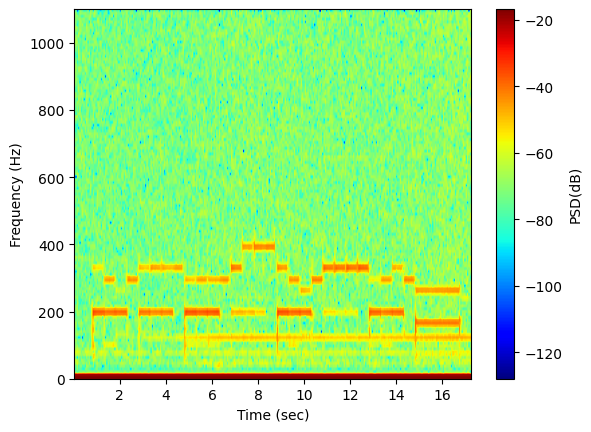

In [109]:
vm.plot_spectogram(x, 2200)

In [12]:
vm.save_audio('test.wav', x)

# Rolling-Shutterを用いた抽出

In [4]:
import pyrtools as pt
import cv2
from scipy import signal
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.io import wavfile
import pandas as pd
from time import time
from scipy.io.wavfile import write

In [133]:
class VM_rolling:
    def __init__(self, video_path):
        self.video_object = cv2.VideoCapture(video_path)
        self.nframes = nframes = int(self.video_object.get(cv2.CAP_PROP_FRAME_COUNT))
        self.height = int(self.video_object.get(cv2.CAP_PROP_FRAME_HEIGHT))
        self.width = int(self.video_object.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.fps = int(self.video_object.get(cv2.CAP_PROP_FPS))
        print(self.width, self.height, self.fps)
        # self.sr = 2200

    def align(self, x, y):
        # print(f'x.shape: {x.shape}')
        # print(f'y.shape: {y.shape}')
        tshift = np.argmax(signal.fftconvolve(x, np.flip(y)))
        shift = y.size - tshift
        return np.roll(x,shift)

    def plot_spectogram(self, x, fs=2200, save=False):
        plt.figure()
        plt.specgram(x, Fs=fs, cmap=plt.get_cmap('jet'))
        plt.xlabel('Time (sec)')
        plt.ylabel('Frequency (Hz)')
        plt.colorbar().set_label('PSD(dB)')
        plt.savefig("spectrogram")

    def get_scaled_sound(self, sound):
        maxs = np.max(sound)
        mins = np.min(sound)

        if maxs!=1.0 or mins!=-1.0:
            rangev = maxs - mins
            print(f'max: {maxs}, mins: {mins}, rengev: {rangev}')
            sound = 2 * sound / rangev
            newmax = np.max(sound)
            offset = newmax - 1.0
            sound -= offset

        return sound

    def save_audio(self, file_name, sound, sr=0):
        if sr==0:
            sr = self.sr
        write(file_name, sr, x)

    def sound_from_video(self, nscale, norientation, downsample_factor, sample_rate=2200):
        ## 初期化
        nframes=self.nframes
        self.sr=sample_rate
        video=self.video_object
        
        ## 1フレーム目の読み出し
        suc,frame = video.read() #reading first frame and considering it reference frame

        ## ダウンサンプリング処理(画像サイズを小さくする)
        if downsample_factor < 1:
            scaled_frame = cv2.resize(frame, (0, 0), fx=downsample_factor, fy=downsample_factor)
        else:
            scaled_frame = frame

        ## gray画像にし、正規化する
        gray_frame = cv2.cvtColor(scaled_frame, cv2.COLOR_BGR2GRAY)
        norm_frame = cv2.normalize(gray_frame.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

        ## SteerablePyramidを計算(初期フレームのみ)
        first_pyr = pt.pyramids.SteerablePyramidFreq(norm_frame,nscale,norientation-1,is_complex=True)
        first_pyr=first_pyr.pyr_coeffs

        ## 初期化
        first_coeff=dict()
        recovered_signal=dict()
        N_gap = 0
        
        for band,coefficient in first_pyr.items():
            first_coeff[band]=coefficient
            recovered_signal[band]=list()

        ## 時間とiterの初期化
        iter=1
        time_start = time()
        time_present=time()

        ## 各フレームで計算
        while suc: #iterating over each frame
            iter+=1
            
            if downsample_factor < 1:
                frame = cv2.resize(frame, (0,0), fx=downsample_factor, fy=downsample_factor)
            
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            norm_frame = cv2.normalize(gray_frame.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
            pyramid = pt.pyramids.SteerablePyramidFreq(norm_frame, nscale, norientation - 1, is_complex=True)
            pyramid=pyramid.pyr_coeffs
            
            amp_pyr=dict()
            phase_diff_pyr = dict()

            for band,coefficient in pyramid.items():
                amp_pyr[band] = abs(coefficient)

            ## 初期フレームとの位相差を計算
            for band,coefficient in pyramid.items():
                phase_diff_pyr[band] = np.mod(math.pi + np.angle(coefficient)-np.angle(first_coeff[band]),2*math.pi) - math.pi
            
            for band in pyramid.keys():
                amp=amp_pyr[band]
                phase_diff=phase_diff_pyr[band]

                for y in range(len(amp[:,0])):
                    ## 重み付け
                    lms=np.multiply(phase_diff[:,y], np.multiply(amp[:,y], amp[:,y]))
                    amp_net = np.sum(amp[:,y])

                    ## 列情報を時間情報にする n=y+(H+N_gap)t
                    recovered_signal[band].append([y + (len(amp) + N_gap) * (iter - 2), np.mean(lms) / amp_net]) 

            ## 次のフレームの読み込み
            suc,frame=video.read()
            time_present = time()

            ## 進捗の表示
            if(iter%50==0):
              print("Progress done: "+str(iter/nframes*100)+"% "+"after "+str(time_present-time_start)+"s.")
        
        ## アップサンプリング(スケールごとの信号長を揃える)
        original_array = recovered_signal['residual_lowpass']
        upsampling_factor = 2
        upsampled_array = []
        for i in range(len(original_array)-1):
            upsampled_array.append(original_array[i])
            for j in range(1, upsampling_factor):
                interpolated_value = (original_array[i+1][1] - original_array[i][1]) * j / upsampling_factor + original_array[i][1]
                upsampled_index = original_array[i][0] + j / upsampling_factor
                upsampled_array.append([upsampled_index, interpolated_value])
        # 最後の要素を追加
        upsampled_array.append(original_array[-1])
        upsampled_array.append(original_array[-1])              
        # 1列目を連番に変更
        upsampled_array = [[i, x[1]] for i, x in enumerate(upsampled_array)]
        recovered_signal['residual_lowpass'] = upsampled_array

        # print(f'recovered_signal[(0,0)]: {recovered_signal[(0,0)][700:1200]}')
        # return
        ## recocered_signalの一部を1次元リストへ変更
        for band in pyramid.keys():
            array = recovered_signal[band]
            new_array = np.zeros(max(array, key=lambda x: x[0])[0] + 1)
            for value in array:
                index = value[0]
                new_array[index] = value[1]              
            recovered_signal[band] =  list(new_array)
            
        ## 復元音声変数の初期化        
        recov_sound=np.zeros(nframes*self.height)
        # print(f'recovered_signal.values: {len(recovered_signal.values())}')    
        
        try:
            for rsignal in recovered_signal.values():
                print(f'rsignal: {rsignal[:500]}')
                # print(f'recovered_signal: {recovered_signal[:500]}')
                recov_sound+=self.align(np.array(rsignal),np.array(recovered_signal[(0,0)]))  
        except:
            print("error")

        print(len(recov_sound))
        
        ## ノイズ除去(ハイパスフィルタ)
        print('Denoising...')
        sos = signal.butter(3, 0.05, btype='highpass', output='sos')
        filtered_sound = signal.sosfilt(sos, recov_sound)

        ## スケーリング
        print('Scaling...')
        filtered_sound = self.get_scaled_sound(filtered_sound)
        
        print(f'filtered_sound: {filtered_sound[:500]}')
        return filtered_sound

In [134]:
video_dir2 = 'KitKat-60Hz-RollingShutter-Mary_MIDI-input.avi'

In [135]:
vm_r = VM_rolling(video_dir2)

1280 720 59


In [136]:
x_r = vm_r.sound_from_video(1, 1, 1)

Progress done: 4.595588235294118% after 11.488649129867554s.
Progress done: 9.191176470588236% after 23.09180784225464s.
Progress done: 13.786764705882353% after 34.85987401008606s.
Progress done: 18.38235294117647% after 46.50031304359436s.
Progress done: 22.977941176470587% after 58.290767669677734s.
Progress done: 27.573529411764707% after 69.92859482765198s.
Progress done: 32.169117647058826% after 81.73176002502441s.
Progress done: 36.76470588235294% after 93.40987586975098s.
Progress done: 41.36029411764706% after 105.08378529548645s.
Progress done: 45.955882352941174% after 116.74574422836304s.
Progress done: 50.55147058823529% after 128.53749322891235s.
Progress done: 55.14705882352941% after 140.1404139995575s.
Progress done: 59.74264705882353% after 151.72521471977234s.
Progress done: 64.33823529411765% after 163.31189632415771s.
Progress done: 68.93382352941177% after 175.16655373573303s.
Progress done: 73.52941176470588% after 186.84062695503235s.
Progress done: 78.125% aft

In [140]:
x_r*100

array([-16.818192  ,   7.42472484,   6.48078259, ...,  14.42495568,
        23.11285045,  19.73722016])

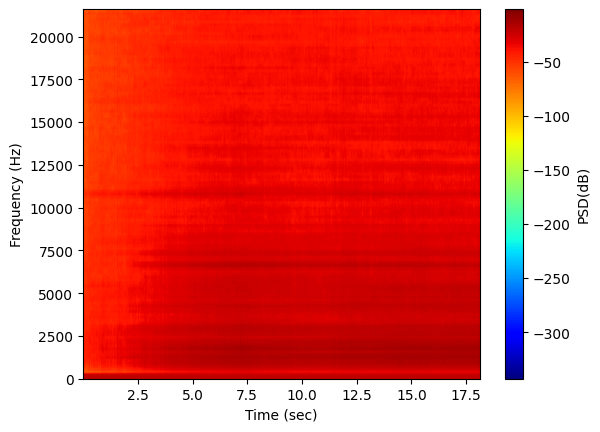

In [138]:
vm_r.plot_spectogram(x_r*100, 720*60)

# pytorch実装を考える

In [2]:
import pyrtools as pt
import cv2
from scipy import signal
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.io import wavfile
import pandas as pd
from time import time
from scipy.io.wavfile import write

In [55]:
a = np.random.rand(7000)
b = np.random.rand(7000)
# a = np.array([1,2,3,4,5]) 
# b = np.array([1,1,1,1,1])

In [56]:
def align_numpy(x, y):
        # print(np.flip(y))
        conv_result = np.convolve(x, np.flip(y))
        print(conv_result.shape)
        print(conv_result)
        tshift = np.argmax(conv_result)
        print(tshift)
        shift = y.size - tshift
        return np.roll(x,shift)

In [57]:
time_before = time()
tmp = align_numpy(a,b)
# tmp = align_numpy(x,y)
time_present = time()
tmp

(13999,)
[0.42663309 0.60138967 0.87578952 ... 0.71982961 0.25654365 0.20001091]
6994


array([0.27718676, 0.59903042, 0.90889652, ..., 0.72164697, 0.95363804,
       0.65505384])

In [58]:
time_present-time_before

0.01126861572265625

In [59]:
def align_numpy(x, y):
        # print(np.flip(y))
        # conv_result = np.convolve(x, np.flip(y))
        conv_result = signal.fftconvolve(x, np.flip(y))
        print(conv_result.shape)
        print(conv_result)
        tshift = np.argmax(conv_result)
        print(tshift)
        shift = y.size - tshift
        return np.roll(x,shift)

In [60]:
time_before = time()
tmp = align_numpy(a,b)
# tmp = align_numpy(x,y)
time_present = time()
tmp

(13999,)
[0.42663309 0.60138967 0.87578952 ... 0.71982961 0.25654365 0.20001091]
6994


array([0.27718676, 0.59903042, 0.90889652, ..., 0.72164697, 0.95363804,
       0.65505384])

In [61]:
time_present-time_before

0.0013060569763183594

In [28]:
import torch
import torchaudio
import numpy as np

def align_torch(x, y):
    x = x.copy()
    y = y.copy()
    x_torch = torch.tensor(x)
    y_torch = torch.tensor(y)
    
    # テンソルを1次元に変換
    x_torch = x_torch.view(1, -1)
    y_torch = y_torch.view(1, -1)

    # yのテンソルを反転
    y_torch = torch.flip(y_torch, dims=[1])

    # print(y_torch)
    
    conv_result = torchaudio.functional.convolve(x_torch, y_torch)
    print(conv_result[:,])
    
    # 最大値のインデックスを取得
    tshift = torch.argmax(conv_result)
    # print(tshift)

    # シフト量を計算
    shift = y_torch.size(1) - tshift

    # テンソルをシフトしてnumpy配列に変換して返す
    return np.roll(x, shift.item())


In [29]:
time_before = time()
tmp = align_torch(a,b)
# tmp = align_torch(x,y)
time_present = time()
tmp

tensor([[ 1,  3,  6, 10, 15, 14, 12,  9,  5]])


array([5, 1, 2, 3, 4])

In [ ]:
time_present-time_before

In [30]:
import torchaudio
import torch

def align_torch_batched(x, y, batch_size):
    num_samples = len(x)
    num_batches = (num_samples + batch_size - 1) // batch_size

    conv_results = []
    for i in range(num_batches):
        start = i * batch_size
        end = min((i + 1) * batch_size, num_samples)

        x_batch = x[start:end]
        y_batch = y[start:end]

        x_torch = torch.tensor(x_batch)
        y_torch = torch.tensor(y_batch)

        x_torch = x_torch.view(1, -1)
        y_torch = y_torch.view(1, -1)
        y_torch = torch.flip(y_torch, dims=[1])

        conv_result = torchaudio.functional.convolve(x_torch, y_torch, mode='same')
        conv_results.append(conv_result)

    print(conv_results)
    # 結果を結合する場合
    conv_results = torch.cat(conv_results, dim=1)
    return conv_results


In [37]:
align_torch_batched(a,b, batch_size=100)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



tensor([[12.5585, 12.1107, 13.0493,  ..., 13.3566, 11.0302, 12.2919]],
       dtype=torch.float64)

In [19]:
x_torch = torch.rand(5)
y_torch = torch.rand(5)
x_torch, y_torch

(tensor([0.4822, 0.9694, 0.1261, 0.9415, 0.6597]),
 tensor([0.2517, 0.0869, 0.8330, 0.1750, 0.9188]))

In [20]:
torchaudio.functional.convolve(x_torch, y_torch)

tensor([0.1213, 0.2859, 0.5176, 1.1398, 0.9656, 1.7543, 0.8302, 0.9804, 0.6061])

In [21]:
torchaudio.functional.convolve(x_torch, y_torch, mode='valid')

tensor([0.9656])

In [22]:
torchaudio.functional.convolve(x_torch, y_torch, mode='same')

tensor([0.5176, 1.1398, 0.9656, 1.7543, 0.8302])